<a href="https://colab.research.google.com/github/sahilkhan-7/stock-price-prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Prediction using Deep Learning**

Predicting future stock prices using LSTM, GRU, and Stacked LSTM models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
import math

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Downloading data for Reliance Industries (RELIANCE.NS)
end_date = datetime.now()
start_date = end_date - timedelta(days=20*365)
stock_symbol = '^NSEI'  # Reliance Industries

In [ ]:
print(f"Downloading data for {stock_symbol} from {start_date.date()} to {end_date.date()}")
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed

In [ ]:
# print("\nData Overview:")
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2007-09-17,4494.649902,4549.049805,4482.850098,4518.450195,0
2007-09-18,4546.200195,4551.799805,4481.549805,4494.100098,0
2007-09-19,4732.350098,4739.000000,4550.250000,4550.250000,0
2007-09-20,4747.549805,4760.850098,4721.149902,4734.850098,0
2007-09-21,4837.549805,4855.700195,4733.700195,4752.950195,0


In [ ]:
# print("Data Info")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4301 entries, 2007-09-17 to 2025-04-02
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^NSEI)   4301 non-null   float64
 1   (High, ^NSEI)    4301 non-null   float64
 2   (Low, ^NSEI)     4301 non-null   float64
 3   (Open, ^NSEI)    4301 non-null   float64
 4   (Volume, ^NSEI)  4301 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 201.6 KB


In [ ]:
df.isnull().sum()

,,0
Price,Ticker,
Close,^NSEI,0
High,^NSEI,0
Low,^NSEI,0
Open,^NSEI,0
Volume,^NSEI,0


In [ ]:
# Handle missing values if any
if df.isnull().sum().sum() > 0:
    df = df.fillna(method='ffill')  # Forward fill
    # Check if any missing values remain
    if df.isnull().sum().sum() > 0:
        df = df.dropna()  # Drop any remaining rows with missing values

print("\nData Shape after handling missing values:", df.shape)


Data Shape after handling missing values: (4301, 5)


## **Feature Engineering**

In [ ]:
# Add moving averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA100'] = df['Close'].rolling(window=100).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Add volatility
df['Volatility'] = df['Close'].rolling(window=20).std()

In [ ]:
df['Price_Change'] = df['Close'].diff()
df['Price_Change_Pct'] = df['Close'].pct_change() * 100

### **Add trading indicators**

In [ ]:
# RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    # Calculate the SMA
    up_sma = up.rolling(window=window).mean()
    down_sma = down.rolling(window=window).mean()

    # Calculate the RSI
    rs = up_sma / down_sma
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
df['RSI'] = calculate_rsi(df['Close'])

In [ ]:
# MACD (Moving Average Convergence Divergence)
def calculate_macd(data, fast=12, slow=26, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

In [ ]:
df['MACD'], df['MACD_Signal'] = calculate_macd(df['Close'])
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

In [ ]:
df['Volume_Change'] = df['Volume'].pct_change() * 100
df['Volume_MA50'] = df['Volume'].rolling(window=50).mean()

In [ ]:
# Day of week (0=Monday, 6=Sunday)
df['Day_of_Week'] = pd.to_datetime(df.index).dayofweek

In [ ]:
df = df.dropna()

In [ ]:
print("Data with Features:")
df.head()

Data with Features:


Price,Close,High,Low,Open,Volume,MA50,MA100,MA200,Volatility,Price_Change,Price_Change_Pct,RSI,MACD,MACD_Signal,MACD_Hist,Volume_Change,Volume_MA50,Day_of_Week
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2013-01-21,6082.299805,6094.350098,6065.100098,6085.750000,130900,5857.329990,5709.044995,5432.117747,70.201230,17.899902,0.295164,69.999945,55.186115,51.745539,3.440575,inf,2618.0,0
2013-01-22,6048.500000,6101.299805,6040.500000,6080.149902,129000,5863.811992,5715.319995,5436.438997,65.530668,-33.799805,-0.555708,57.107931,53.751292,52.146690,1.604602,-1.451490,5198.0,1
2013-01-23,6054.299805,6069.799805,6021.149902,6052.850098,137000,5869.695986,5721.734492,5440.494746,60.029127,5.799805,0.095888,55.922763,52.477256,52.212803,0.264453,6.201550,7938.0,2
2013-01-24,6019.350098,6065.299805,6007.850098,6046.200195,185200,5875.307988,5727.774492,5444.617747,56.599219,-34.949707,-0.577271,50.393628,48.093037,51.388850,-3.295813,35.182482,11642.0,3
2013-01-25,6074.649902,6080.549805,6014.450195,6024.500000,147600,5883.075986,5734.653989,5449.096746,50.258875,55.299805,0.918701,59.935496,48.521419,50.815364,-2.293945,-20.302376,14594.0,4


## **Visualizations**

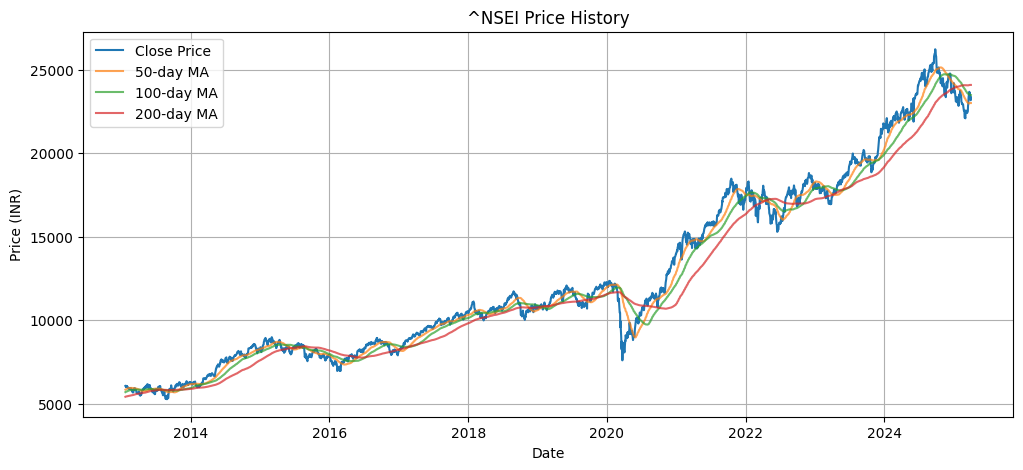

In [ ]:
# Stock price history
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['MA50'], label='50-day MA', alpha=0.7)
plt.plot(df.index, df['MA100'], label='100-day MA', alpha=0.7)
plt.plot(df.index, df['MA200'], label='200-day MA', alpha=0.7)
plt.title(f'{stock_symbol} Price History')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df.index

DatetimeIndex(['2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24',
               '2013-01-25', '2013-01-28', '2013-01-29', '2013-01-30',
               '2013-01-31', '2013-02-01',
               ...
               '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24',
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-04-01', '2025-04-02'],
              dtype='datetime64[ns]', name='Date', length=2993, freq=None)

In [ ]:
# df.index = pd.to_datetime(df.index)

In [ ]:
import plotly.express as px

fig = px.bar(df, x=df.index, y=df['Volume'].squeeze(),
             title="Trading Volume",
             labels={'Volume': 'Volume', 'index': 'Date'},
             opacity=0.5, color_discrete_sequence=['purple'])

fig.add_scatter(x=df.index, y=df['Volume_MA50'].squeeze(),
                mode='lines', name='50-day Volume MA',
                line=dict(color='orange'))

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Volume")
fig.update_layout(xaxis=dict(showgrid=True), yaxis=dict(showgrid=True))

fig.show()


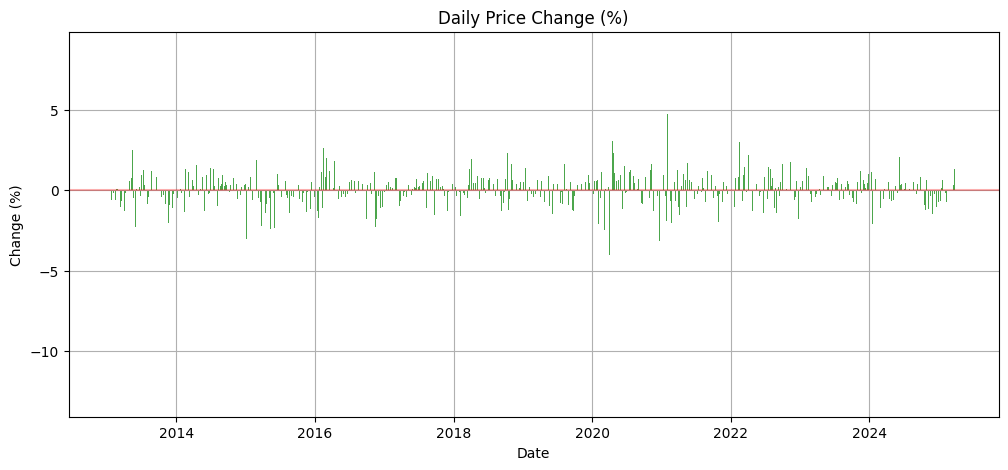

In [ ]:
# Price Change Percentage
plt.figure(figsize=(12, 5))
plt.bar(df.index, df['Price_Change_Pct'], color='green', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Daily Price Change (%)')
plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.grid(True)
plt.show()

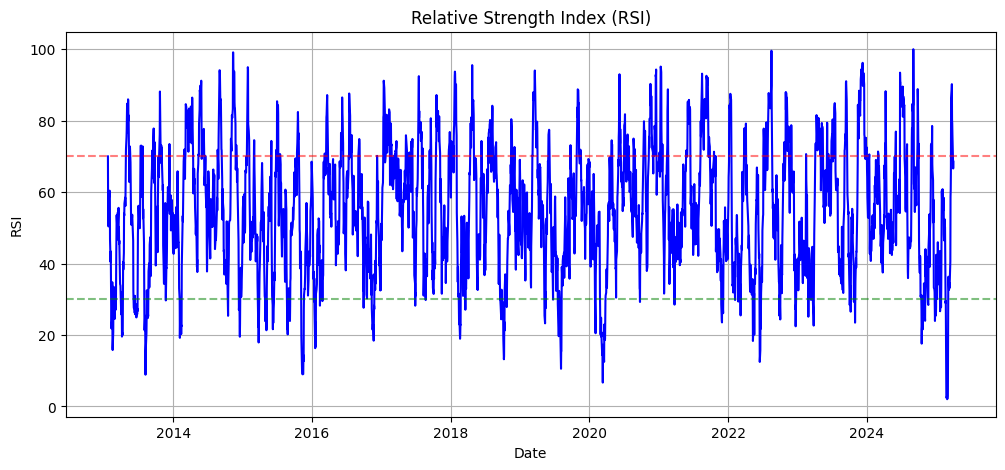

In [ ]:
# RSI
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['RSI'], color='blue')
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.show()

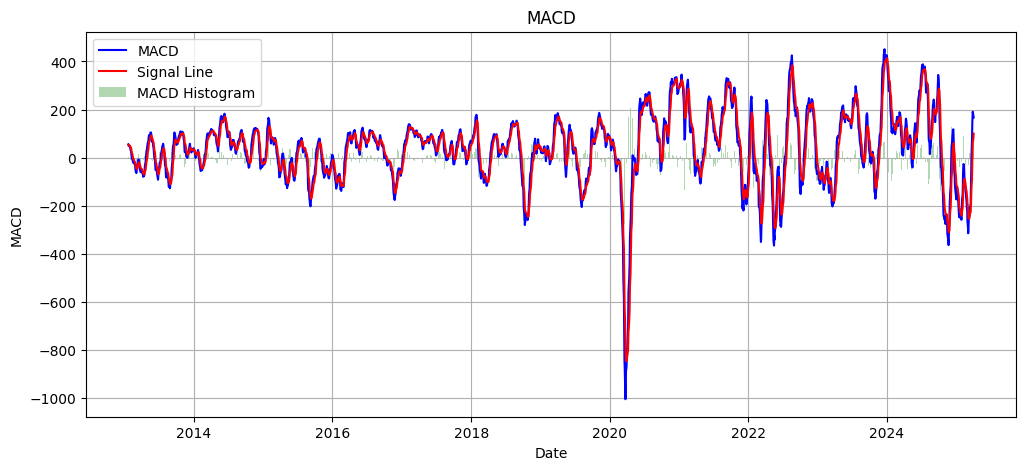

In [ ]:
# MACD
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['MACD_Signal'], label='Signal Line', color='red')
plt.bar(df.index, df['MACD_Hist'], label='MACD Histogram', color='green', alpha=0.3)
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.show()

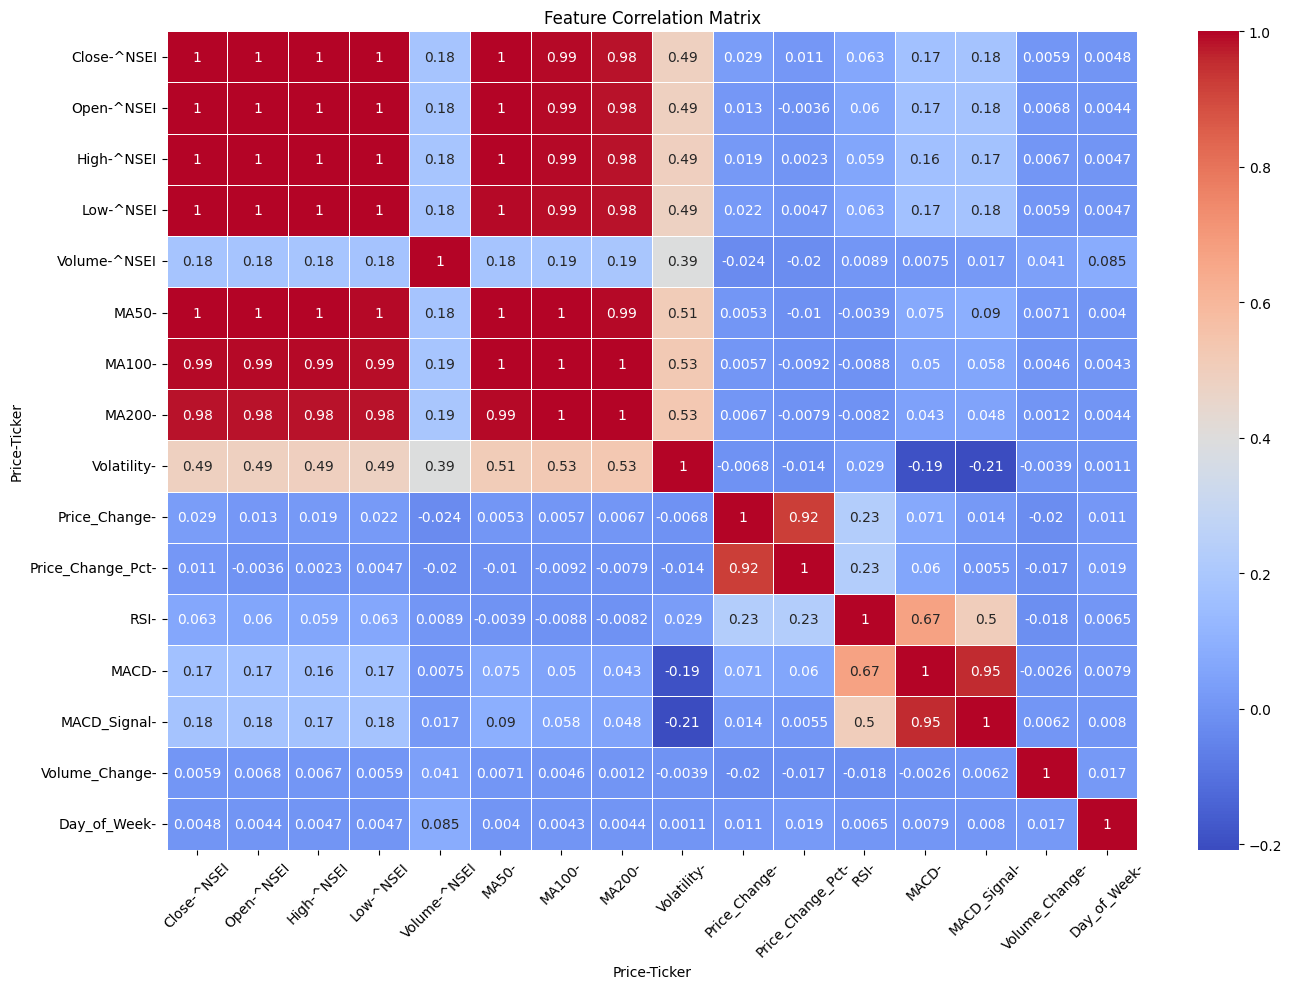

In [ ]:
plt.figure(figsize=(14, 10))
correlation_columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA50', 'MA100', 'MA200', 'Volatility',
                       'Price_Change', 'Price_Change_Pct', 'RSI', 'MACD', 'MACD_Signal',
                       'Volume_Change', 'Day_of_Week']
correlation_matrix = df[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
df.columns

MultiIndex([(           'Close', '^NSEI'),
            (            'High', '^NSEI'),
            (             'Low', '^NSEI'),
            (            'Open', '^NSEI'),
            (          'Volume', '^NSEI'),
            (            'MA50',      ''),
            (           'MA100',      ''),
            (           'MA200',      ''),
            (      'Volatility',      ''),
            (    'Price_Change',      ''),
            ('Price_Change_Pct',      ''),
            (             'RSI',      ''),
            (            'MACD',      ''),
            (     'MACD_Signal',      ''),
            (       'MACD_Hist',      ''),
            (   'Volume_Change',      ''),
            (     'Volume_MA50',      ''),
            (     'Day_of_Week',      '')],
           names=['Price', 'Ticker'])

In [ ]:
# Data Preparation for Model Training
feature_columns = ['Close', 'Open', 'High', 'Low', 'Volume',
                   'MA50', 'MA100', 'MA200', 'Volatility']

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
df.isnull().sum()

,,0
Price,Ticker,
Close,^NSEI,0
High,^NSEI,0
Low,^NSEI,0
Open,^NSEI,0
Volume,^NSEI,0
MA50,,0
MA100,,0
MA200,,0
Volatility,,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
# Normalizing  data using minmax scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[feature_columns])

# creating a separate scaler for closing prices to invert predictions later
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit_transform(df[['Close']])

array([[0.03647691],
       [0.036754  ],
       [0.03508424],
       ...,
       [0.87116265],
       [0.85426668],
       [0.86222855]])

## **Splitting the Data**

In [ ]:
# Function to create sequences for LSTM/GRU training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        # Predict next day's closing price (which is the first column in our data)
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 100  # 100 days of data to predict the next day

In [ ]:
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (2293, 100, 9)
Testing data shape: (574, 100, 9)


## **Creating Models**

In [ ]:
# Define function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    predictions = model.predict(X_test)

    # Reshape for inverse scaling
    predictions_reshaped = np.zeros((len(predictions), len(feature_columns)))
    predictions_reshaped[:, 0] = predictions.flatten()

    # Inverse transform to get actual prices
    predictions_actual = close_scaler.inverse_transform(predictions_reshaped[:, 0].reshape(-1, 1))

    # Get actual test values
    y_test_reshaped = np.zeros((len(y_test), len(feature_columns)))
    y_test_reshaped[:, 0] = y_test
    y_test_actual = close_scaler.inverse_transform(y_test_reshaped[:, 0].reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(y_test_actual, predictions_actual)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    r2 = r2_score(y_test_actual, predictions_actual)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

    print(f"\n{model_name} Evaluation:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # Plot predictions vs actual
    plt.figure(figsize=(16, 8))
    plt.plot(y_test_actual, color='blue', label='Actual Price')
    plt.plot(predictions_actual, color='red', label=f'{model_name} Predictions')
    plt.title(f'{stock_symbol} Price Prediction - {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.grid(True)

    return rmse, predictions_actual, y_test_actual

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Model 1: Simple LSTM
print("\nBuilding Simple LSTM Model...")
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))


Building Simple LSTM Model...


In [ ]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0091 - val_loss: 0.0021
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.4994e-04 - val_loss: 5.2994e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4245e-04 - val_loss: 7.2643e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0774e-04 - val_loss: 5.5215e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2147e-04 - val_loss: 7.3343e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8030e-04 - val_loss: 6.6084e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4982e-04 - val_loss: 0.0011
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5319e-04 - val_loss: 0.0012
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6215e-04 - val_loss: 4.0421e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.9220e-04 - val_loss: 5.5154e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.0417e-04 - val_loss: 0.

In [ ]:
print("\nBuilding Stacked LSTM Model...")
stacked_lstm_model = Sequential()
stacked_lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
stacked_lstm_model.add(LSTM(units=128, return_sequences=True))
stacked_lstm_model.add(Dropout(0.2))
stacked_lstm_model.add(LSTM(units=128, return_sequences=True))
stacked_lstm_model.add(Dropout(0.2))
stacked_lstm_model.add(LSTM(units=128))
stacked_lstm_model.add(Dropout(0.2))
stacked_lstm_model.add(Dense(units=1))


Building Stacked LSTM Model...


In [ ]:
stacked_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
stacked_lstm_history = stacked_lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3290e-04 - val_loss: 6.3090e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2111e-04 - val_loss: 4.4928e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.6291e-04 - val_loss: 6.0703e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.2338e-04 - val_loss: 4.0369e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.9936e-04 - val_loss: 3.8783e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9363e-04 - val_loss: 0.0018
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.3145e-04 - val_loss: 3.7386e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.7612e-04 - val_loss: 3.6535e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6112e-04 - val_loss: 0.0010
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5006e-04 - val_loss: 4.

In [ ]:
print("\nBuilding Stacked LSTM Model...")
deep_stacked_lstm_model = Sequential()
deep_stacked_lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
deep_stacked_lstm_model.add(LSTM(units=128, return_sequences=True))
deep_stacked_lstm_model.add(Dropout(0.2))
deep_stacked_lstm_model.add(LSTM(units=128, return_sequences=True))
deep_stacked_lstm_model.add(Dropout(0.2))
deep_stacked_lstm_model.add(LSTM(units=128, return_sequences=True))
deep_stacked_lstm_model.add(Dropout(0.2))
deep_stacked_lstm_model.add(LSTM(units=128))
deep_stacked_lstm_model.add(Dropout(0.2))
deep_stacked_lstm_model.add(Dense(units=1))


Building Stacked LSTM Model...


In [ ]:
deep_stacked_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
deep_stacked_lstm_history = deep_stacked_lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0069 - val_loss: 0.0041
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.1590e-04 - val_loss: 0.0022
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.4549e-04 - val_loss: 6.2921e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.6801e-04 - val_loss: 0.0025
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.6070e-04 - val_loss: 0.0019
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 3.2250e-04 - val_loss: 7.8124e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5989e-04 - val_loss: 9.6733e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0445e-04 - val_loss: 4.7772e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.3903e-04 - val_loss: 0.0011
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.0379e-04 - val_loss: 4.3119e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6890e-04 - val_loss: 9.2345e-04

In [ ]:
# Model 3: GRU Model
print("\nBuilding GRU Model...")
gru_model = Sequential()
gru_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(GRU(units=50, return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1))


Building GRU Model...


In [ ]:
gru_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 100, 50)             │           9,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,501 (95.71 KB)

 Trainable params: 24,501 (95.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.4993e-04 - val_loss: 2.7172e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.5911e-04 - val_loss: 2.6834e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.4751e-04 - val_loss: 2.3986e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0089e-04 - val_loss: 4.7580e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8245e-04 - val_loss: 1.8866e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9276e-04 - val_loss: 3.1245e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8083e-04 - val_loss: 1.8227e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6923e-04 - val_loss: 1.8246e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0977e-04 - val_loss: 1.7204e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.2006e-04 - val_

### **Model Evaluation**

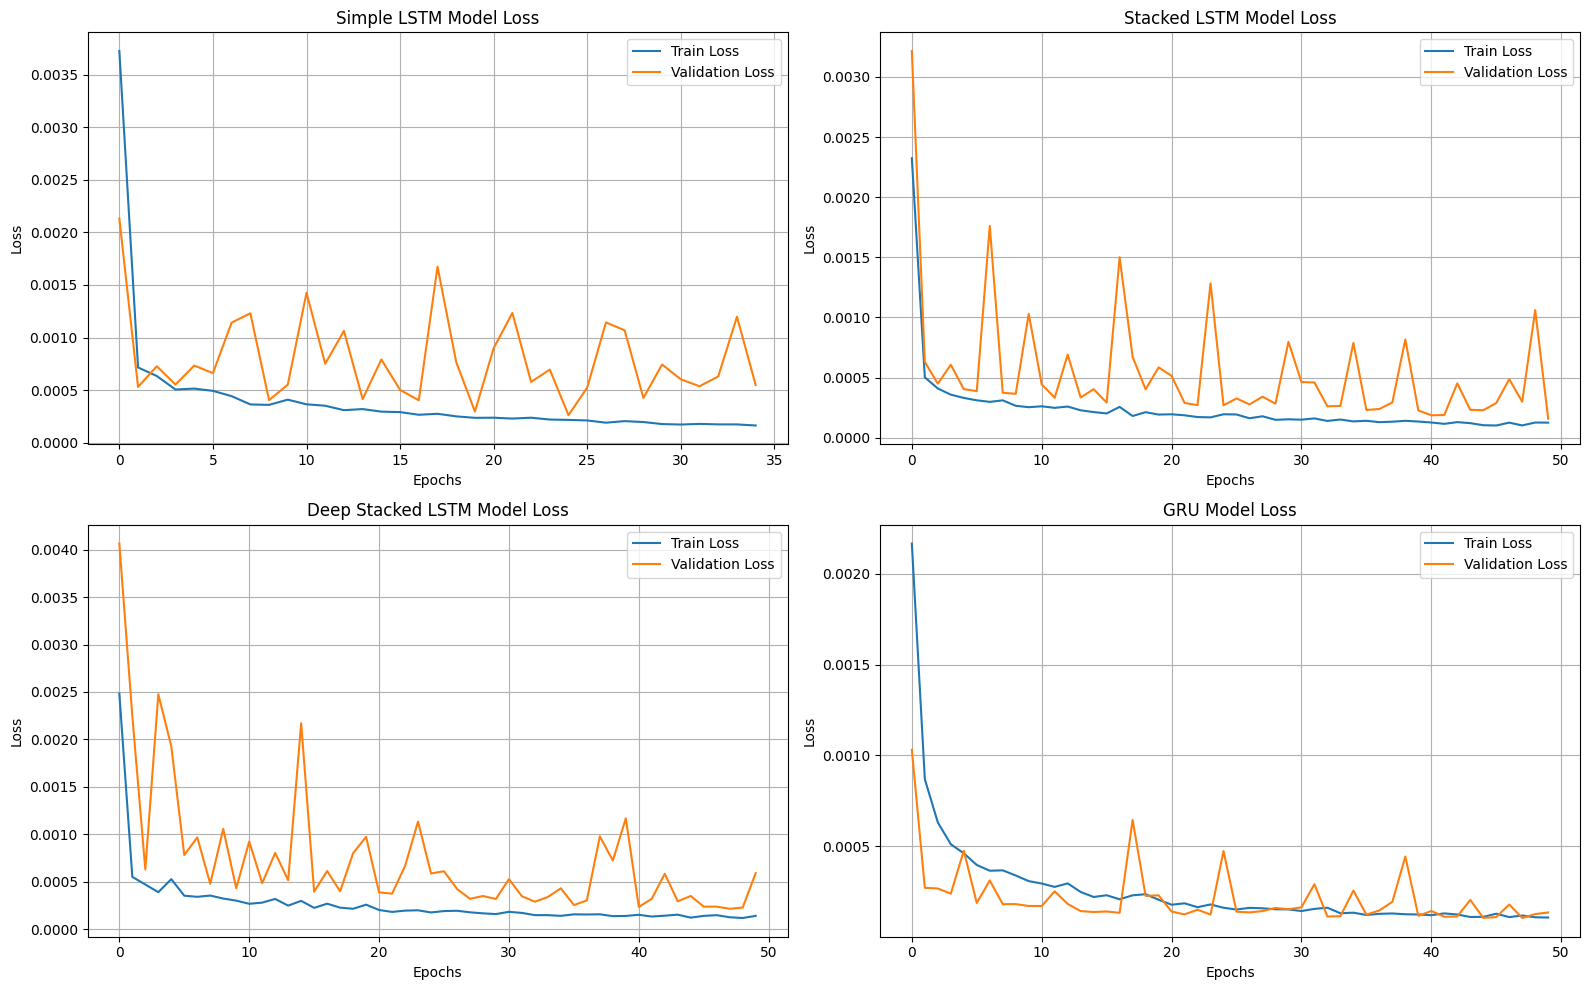

In [ ]:
# Plot training history for all models
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Simple LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(stacked_lstm_history.history['loss'], label='Train Loss')
plt.plot(stacked_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(deep_stacked_lstm_history.history['loss'], label='Train Loss')
plt.plot(deep_stacked_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Deep Stacked LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Simple LSTM Evaluation:
MSE: 374062.74
RMSE: 611.61
MAE: 482.58
R²: 0.9419
MAPE: 2.15%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Stacked LSTM Evaluation:
MSE: 273275.50
RMSE: 522.76
MAE: 424.80
R²: 0.9576
MAPE: 1.90%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Deep Stacked LSTM Evaluation:
MSE: 365632.02
RMSE: 604.68
MAE: 481.44
R²: 0.9432
MAPE: 2.15%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

GRU Evaluation:
MSE: 73227.07
RMSE: 270.61
MAE: 211.68
R²: 0.9886
MAPE: 0.97%


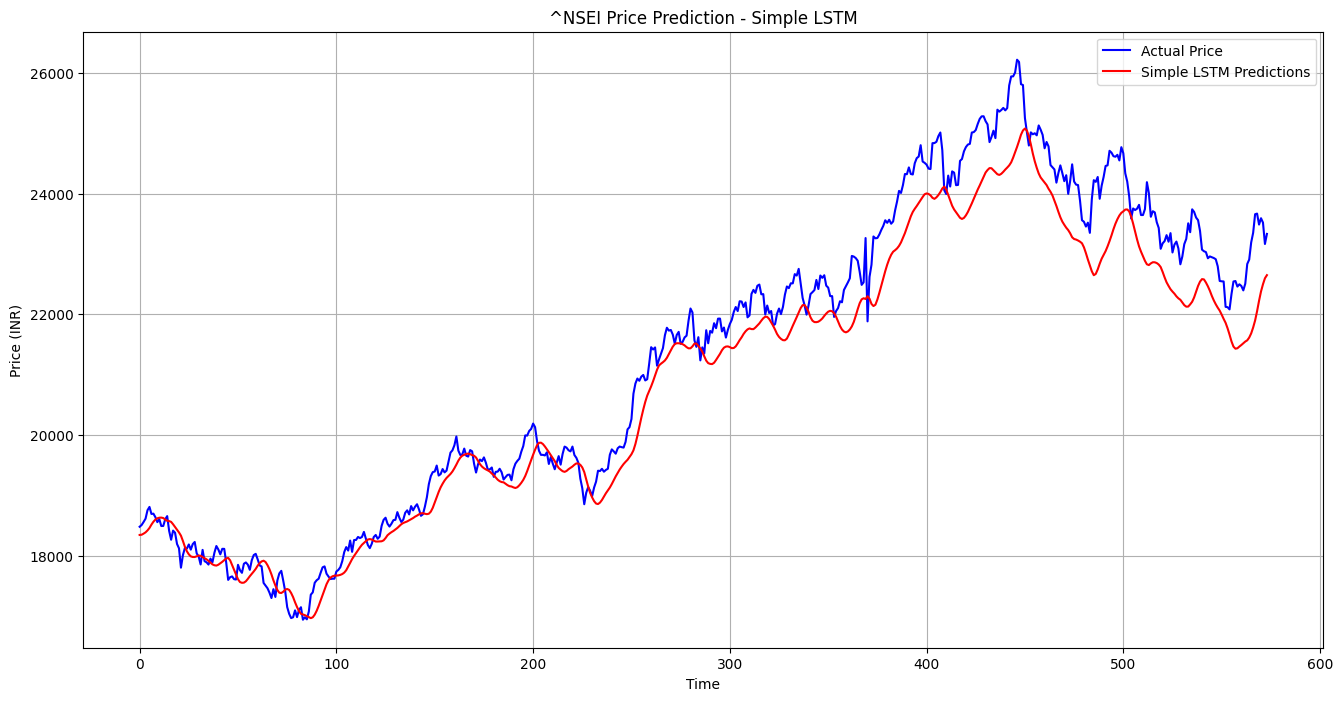

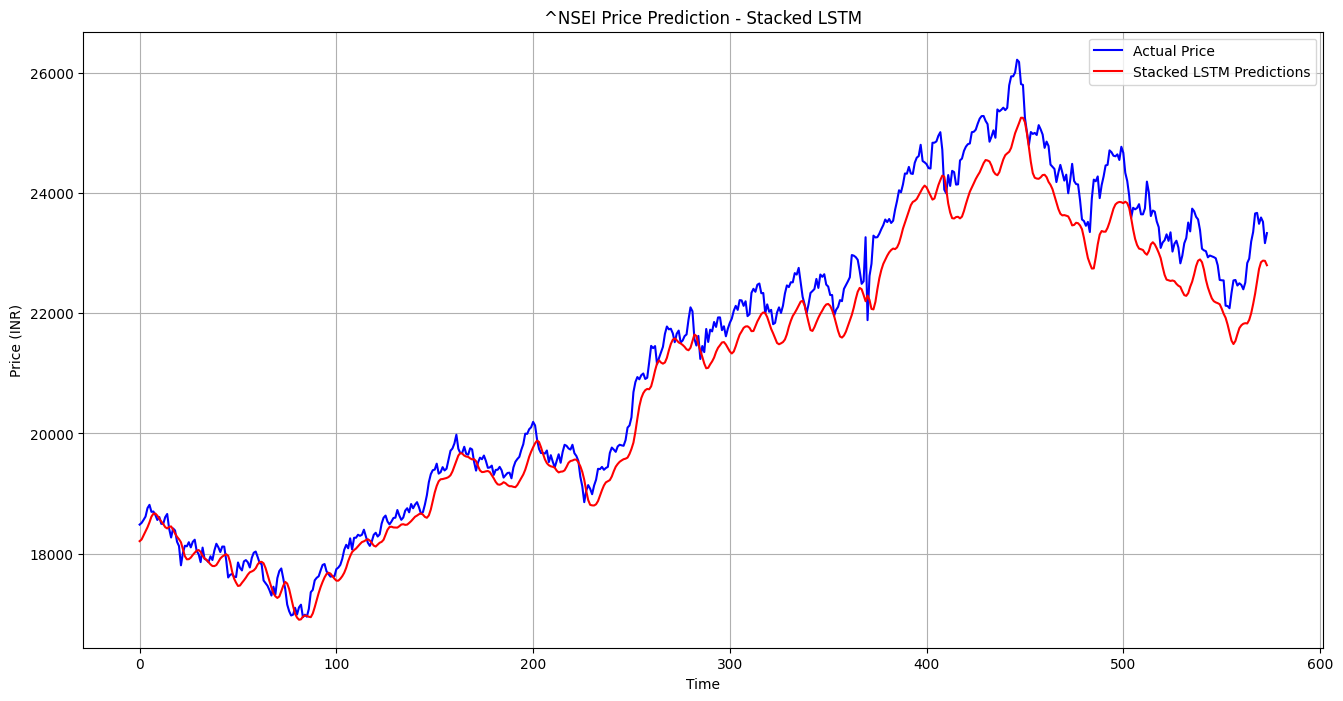

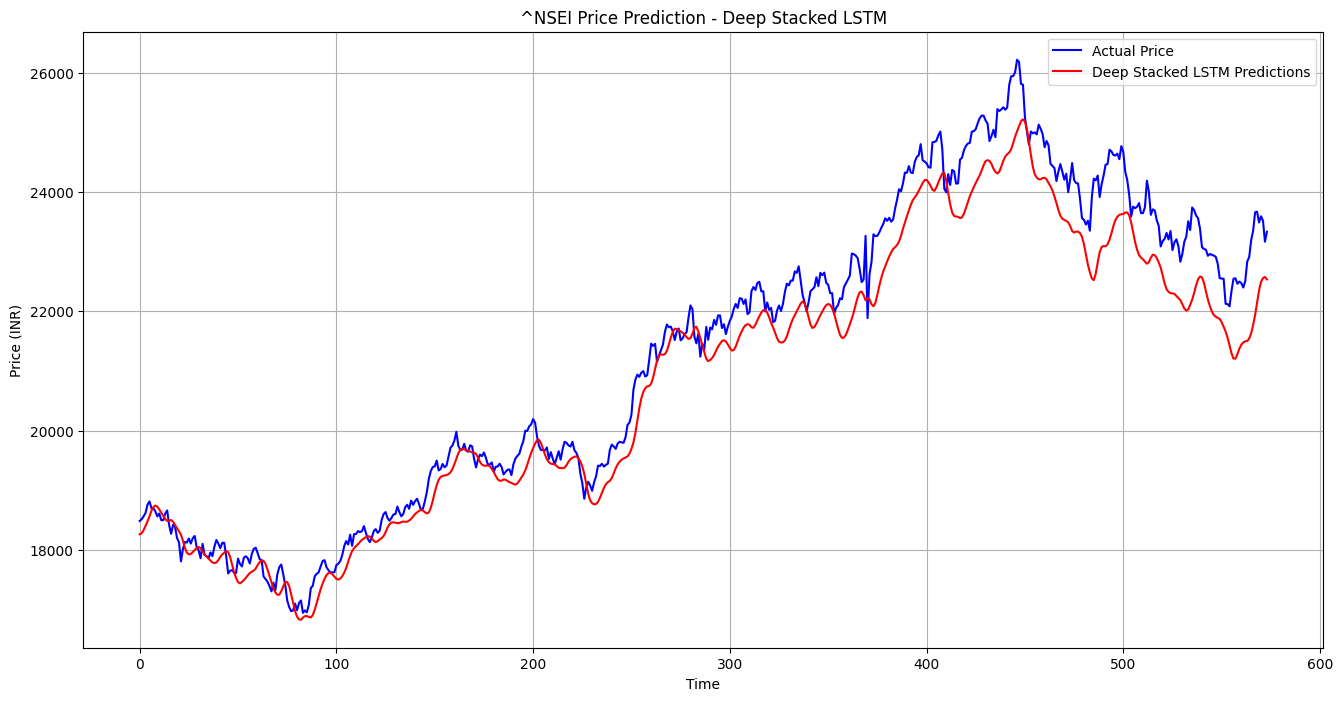

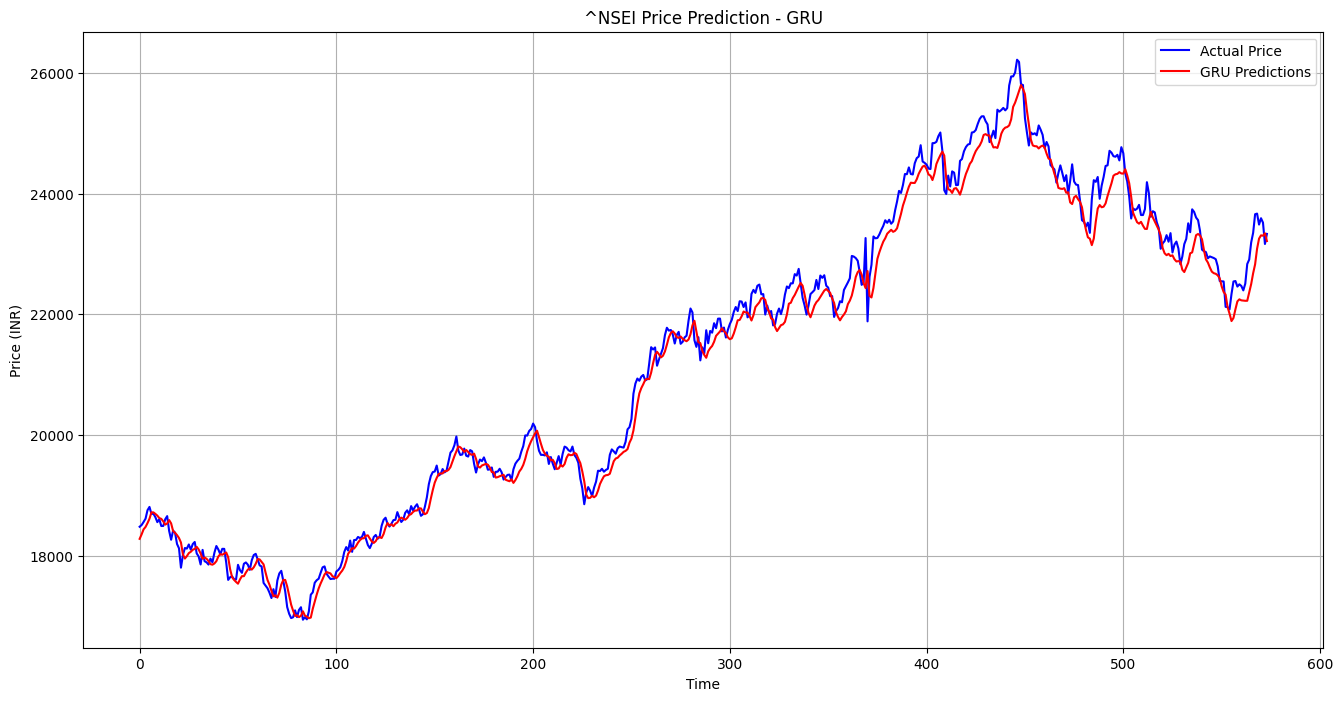

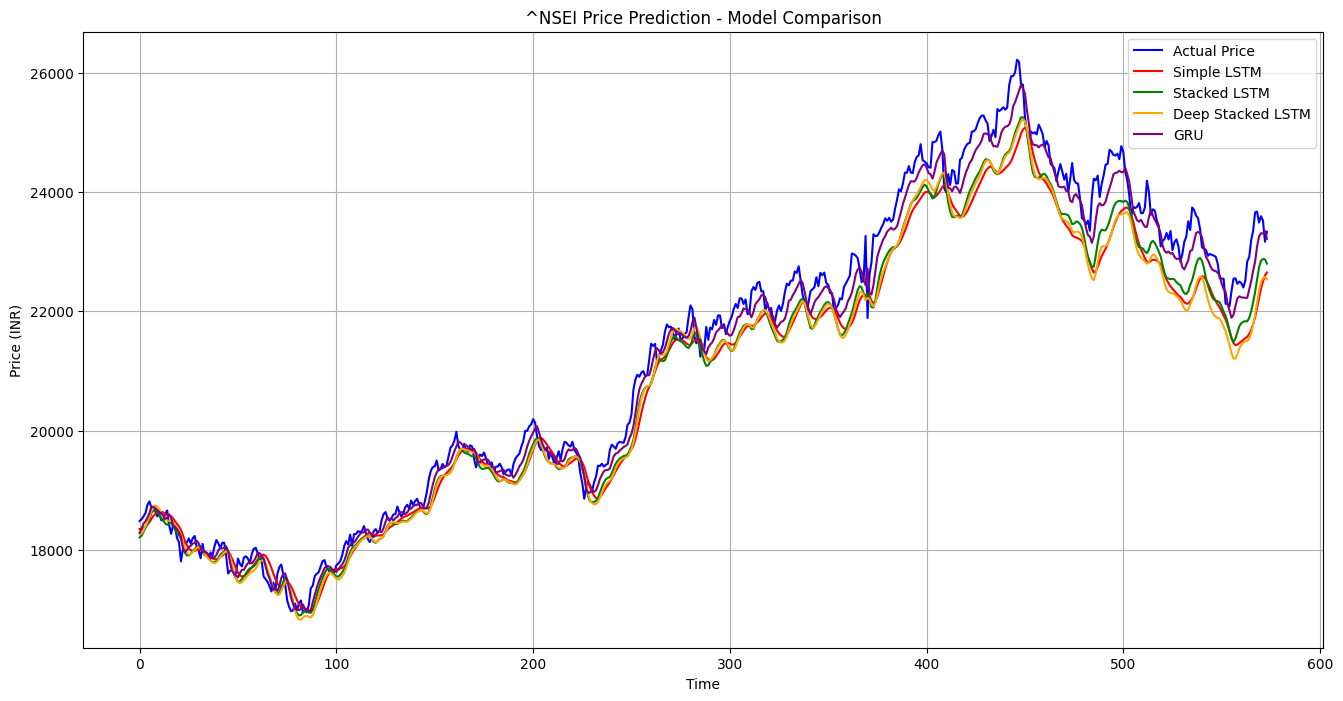

In [ ]:
# Evaluate all models
rmse_lstm, pred_lstm, actual = evaluate_model(lstm_model, X_test, y_test, "Simple LSTM")
rmse_stacked, pred_stacked, _ = evaluate_model(stacked_lstm_model, X_test, y_test, "Stacked LSTM")
rmse_deep_stacked, pred_deep_stacked, _ = evaluate_model(deep_stacked_lstm_model, X_test, y_test, "Deep Stacked LSTM")
rmse_gru, pred_gru, _ = evaluate_model(gru_model, X_test, y_test, "GRU")

# Compare all models in one plot
plt.figure(figsize=(16, 8))
plt.plot(actual, color='blue', label='Actual Price')
plt.plot(pred_lstm, color='red', label='Simple LSTM')
plt.plot(pred_stacked, color='green', label='Stacked LSTM')
plt.plot(pred_deep_stacked, color='orange', label='Deep Stacked LSTM')
plt.plot(pred_gru, color='purple', label='GRU')
plt.title(f'{stock_symbol} Price Prediction - Model Comparison')
plt.xlabel('Time')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)

### **Comparing All Models**

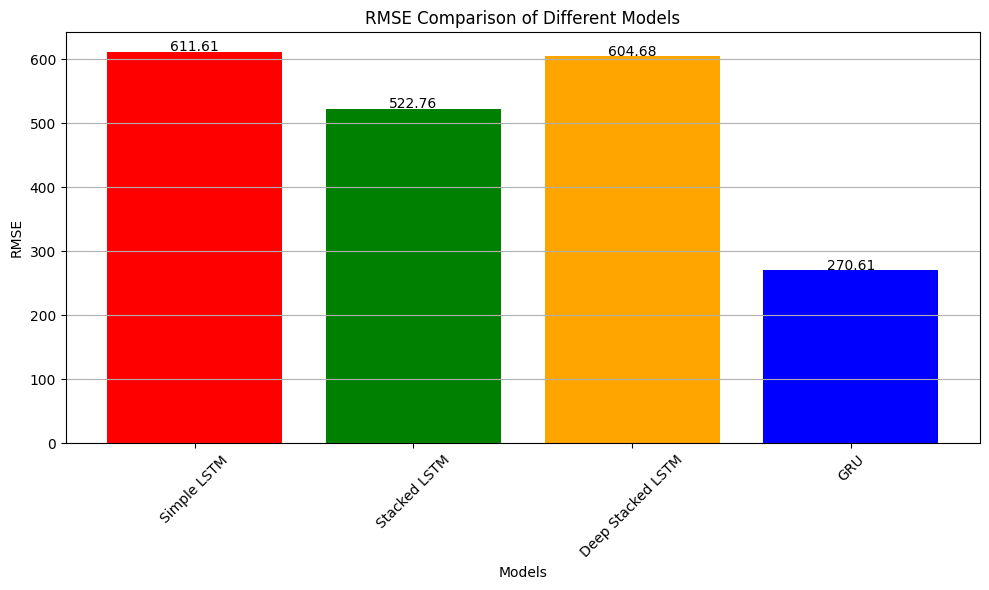

In [ ]:
# Compare RMSE of all models
models = ['Simple LSTM', 'Stacked LSTM', 'Deep Stacked LSTM', 'GRU']
rmse_values = [rmse_lstm, rmse_stacked, rmse_deep_stacked, rmse_gru]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['red', 'green', 'orange', 'blue'])
plt.title('RMSE Comparison of Different Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

for i, v in enumerate(rmse_values):
    plt.text(i, v + 1, f"{v:.2f}", ha='center')

plt.tight_layout()

## **Making Predictions for Future**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

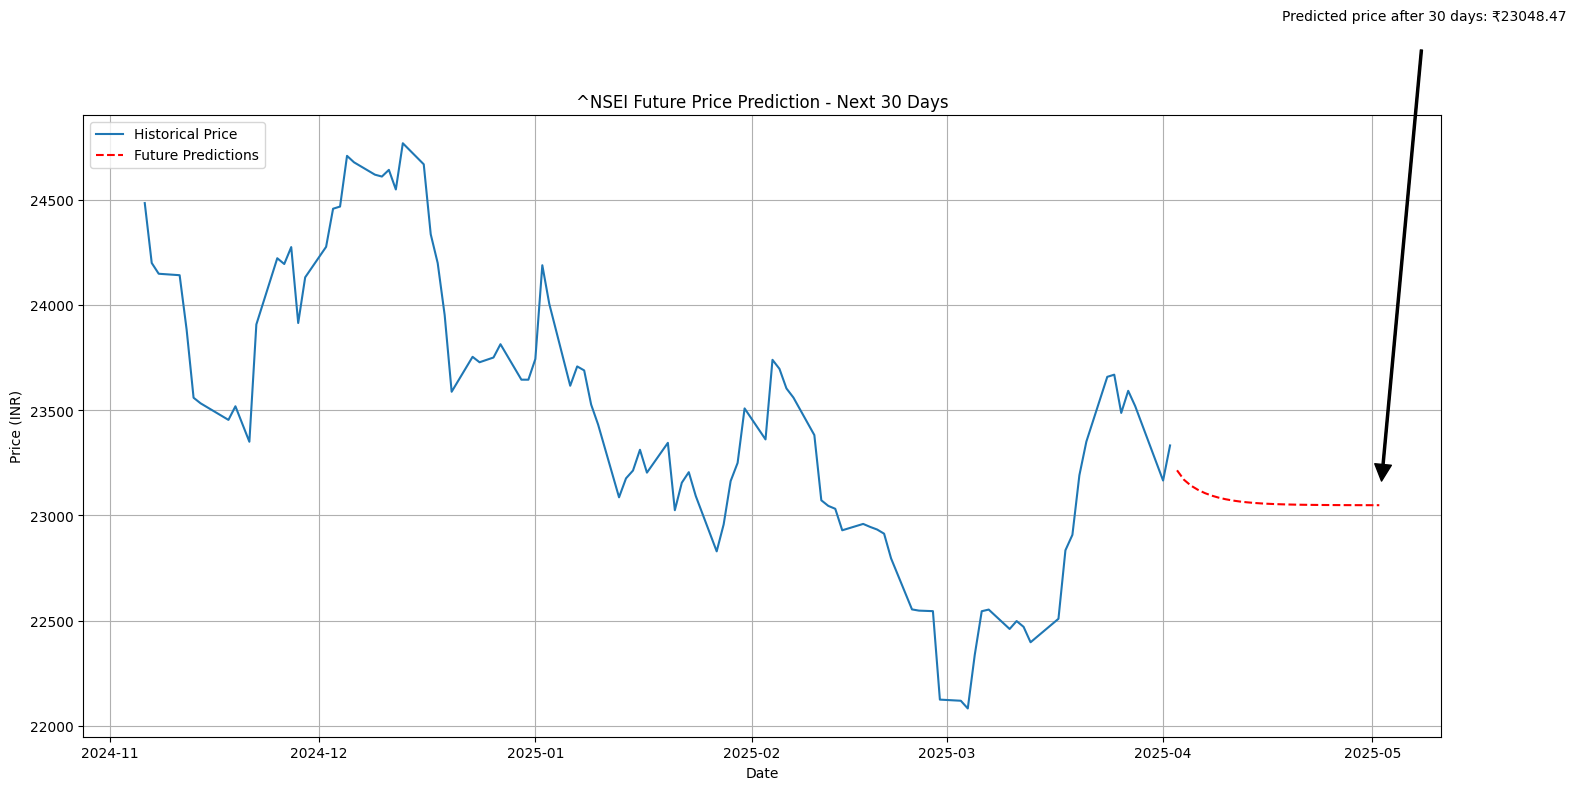

In [ ]:
# Function to predict the next 30 days
def predict_future(model, last_sequence, days=30):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Reshape for prediction
        current_sequence_reshaped = current_sequence.reshape(1, seq_length, X_train.shape[2])

        # Get prediction (scaled)
        next_pred = model.predict(current_sequence_reshaped)[0, 0]
        future_predictions.append(next_pred)

        # Update sequence for next prediction
        # Create a new row with the predicted value as the Close price
        # For other features, we'll just use the last values (not ideal but simplistic)
        new_row = current_sequence[-1].copy()
        new_row[0] = next_pred  # Update the Close price with our prediction

        # Remove first element and append the new prediction
        current_sequence = np.vstack([current_sequence[1:], new_row])

    # Convert scaled predictions back to actual prices
    future_predictions_reshaped = np.zeros((len(future_predictions), len(feature_columns)))
    future_predictions_reshaped[:, 0] = np.array(future_predictions).flatten()
    future_predictions_actual = close_scaler.inverse_transform(future_predictions_reshaped[:, 0].reshape(-1, 1))

    return future_predictions_actual

# Get the last sequence from our test data
last_sequence = X_test[-1]

# Use the best performing model for future prediction (let's assume it's the Bidirectional LSTM)
best_model = gru_model
if rmse_stacked < min(rmse_lstm, rmse_gru, rmse_deep_stacked):
    best_model = stacked_lstm_model
elif rmse_deep_stacked < min(rmse_lstm, rmse_stacked, rmse_gru):
    best_model = deep_stacked_lstm_model
elif rmse_lstm < min(rmse_stacked, rmse_gru, rmse_deep_stacked):
    best_model = lstm_model

# Make 30-day future predictions
future_predictions = predict_future(best_model, last_sequence, days=30)

# Create future dates for plotting
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)

# Plot future predictions
plt.figure(figsize=(16, 8))
# Plot historical data
plt.plot(df[-100:].index, df[-100:]['Close'], label='Historical Price')
# Plot future predictions
plt.plot(future_dates, future_predictions, 'r--', label='Future Predictions')
plt.title(f'{stock_symbol} Future Price Prediction - Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)

# Add text to the plot showing the predicted price for the last day
future_price = future_predictions[-1][0]
plt.annotate(f'Predicted price after 30 days: ₹{future_price:.2f}',
             xy=(future_dates[-1], future_price),
             xytext=(future_dates[-15], future_price * 1.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.tight_layout()



In [ ]:
# Summary of the models
print("\nModel Comparison Summary:")
print("-" * 50)
print(f"{'Model':<20} {'RMSE':<10}")
print("-" * 50)
print(f"{'Simple LSTM':<20} {rmse_lstm:<10.2f}")
print(f"{'Stacked LSTM':<20} {rmse_stacked:<10.2f}")
print(f"{'Deep Stacked LSTM':<20} {rmse_deep_stacked:<10.2f}")
print(f"{'GRU':<20} {rmse_gru:<10.2f}")
print("-" * 50)
best_model_name = models[rmse_values.index(min(rmse_values))]
print(f"Best model: {best_model_name} with RMSE: {min(rmse_values):.2f}")


Model Comparison Summary:
--------------------------------------------------
Model                RMSE      
--------------------------------------------------
Simple LSTM          611.61    
Stacked LSTM         522.76    
Deep Stacked LSTM    604.68    
GRU                  270.61    
--------------------------------------------------
Best model: GRU with RMSE: 270.61
